# Coefficient Shrinkage
$\providecommand{\bbeta}{\boldsymbol\beta}$
$\providecommand{\bx}{\boldsymbol x}$

The purpose of this library is to fit additive models
\begin{equation*}
E[Y | X=\bx] = \mu(\beta_1 h_1(\bx)+\dots+\beta_k h_k(\bx))
\end{equation*}
over dynamically created feature functions $f$ using the gradient boosting framework.

\begin{equation}
\mathcal{R}_\lambda(\bbeta; h) = \sum_{i=1}^n \ell(y_i, f(\bx_i)) + \lambda \Omega(\bbeta)
\end{equation}

One standard choice for the penalty term is $l2$-regularisation that uses $\Omega(\bbeta)=\|\bbeta\|_2$. This is very easy to implement for the weight fitting step, at least in the context of least-squares regression. However, as the penalty term is not directly given as a function of the model output, it is not straightforward to incorporate it into several of the standard objective functions in gradient boosting, because those are a function of the risk gradient of the model output (and not, at least not directly, of the coefficients).
As a consequence, those objective function might overestimates the risk reduction achieved by terms that would get a very large unshrunken coefficient.

## A Failed Example to Illustrate the Shortcoming of Gradient Sum with Shrinkage

The following example turns out ot be too simplistic to demonstrate the shortcoming of not incorporating the penalty into the objective function, at least for gradient sum. The intuition is that there is a small coverage rule with extreme values, which after shrinkage, provides less empirical risk reduction than a large coverage rule with less extreme values, and thereby misleads gradient sum to pick a sub-optimal rule.

However in reality, by playing with the concrete numbers, it seems to be become evident that gradient sum always picks the right rule. Particularly, if it picks the small group, the risk reduction is in fact still better after shrinkage. We note that this might be different with the traditional gradient boosting objective, but for now move on to other aspects of shrinkage.

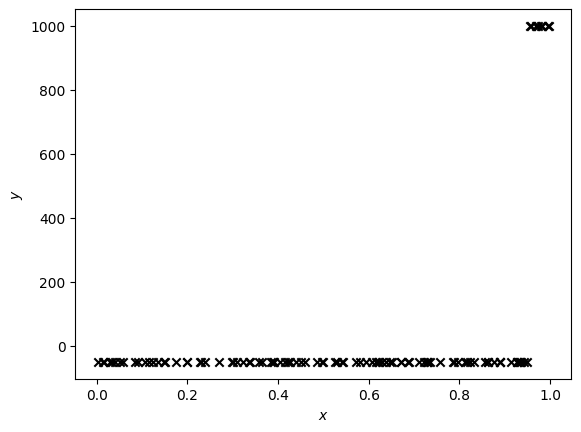

In [80]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(seed=0)
x = RNG.uniform(size=100).reshape(-1, 1)
# y = (x**2).reshape(-1)
y = RNG.binomial(1, expit(1000*(x-0.95))).reshape(-1)
y = 1000*y
y[y==0] = -50

plt.scatter(x, y, marker='x', color='black')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.show()

In [143]:
from optikon import max_weighted_support, equal_width_propositionalization
from sklearn.metrics import mean_squared_error

class RuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, normalize_during_weight_fit=False, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.normalize_during_weight_fit = normalize_during_weight_fit
        self.lam = lam

    def fit(self, x, y):
        n = len(x)
        props = equal_width_propositionalization(x)
        
        q_matrix = np.zeros(shape=(n, self.num_rules+self.fit_intercept))

        if self.fit_intercept:
            self.q_ = [props[:0]]
            q_matrix[:, 0] = 1
            self.coef_ = np.array([y.mean()])
        else:
            self.q_ = []
            q_matrix = np.zeros(shape=(n, self.num_rules))
            self.coef_ = np.zeros(shape=0)

        for i in range(self.fit_intercept, self.num_rules+self.fit_intercept):
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = y - y_hat

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            self._fit_coefficients(y, q_matrix[:, :i+1])

        return self

    def _fit_coefficients(self, y, q_matrix):
        
        if self.normalize_during_weight_fit:
            b = q_matrix.sum(axis=0)**0.5 / len(y)**0.5
            q_matrix = q_matrix / b
            print(b)

        gramian = q_matrix.T.dot(q_matrix)

        if self.lam > 0:
            if self.fit_intercept:
                gramian[np.diag_indices_from(gramian)[0][1:], np.diag_indices_from(gramian)[1][1:]] += self.lam
            else:
                gramian[np.diag_indices_from(gramian)] += self.lam

        self.coef_ = np.linalg.solve(gramian, q_matrix.T.dot(y))

        if self.normalize_during_weight_fit:
            self.coef_ /= b
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'RuleBoostingRegressor({self.num_rules}, {self.max_depth})'
    
regressor_lam100 = RuleBoostingRegressor(num_rules=1, fit_intercept=False, lam=1000).fit(x, y)
print(regressor_lam100)
mean_squared_error(y, regressor_lam100.predict(x))

+0.036 if  


0.23134326166650493

In [82]:
regressor_lam100_injected_rule = RuleBoostingRegressor(num_rules=1, fit_intercept=False, lam=1000)
props = equal_width_propositionalization(x)
regressor_lam100_injected_rule.q_ = [props[-1:]]
regressor_lam100_injected_rule._fit_coefficients(y, regressor_lam100_injected_rule._compute_q_matrix(x))
print(regressor_lam100_injected_rule)
mean_squared_error(y, regressor_lam100_injected_rule.predict(x))


-3.875 if x1 <= 0.892 


81987.14886779862

## Effect of Rule Coverage on Shrinkage

In the case of rule ensembles the basic functions become binary queries $q$. In this case, we can connect the effect of shrinkage to the coverage or support count of a rule, i.e., the number of data points for which $q(x_i)=1$.
For a single rule (or more generally is the rule coverage vector is orthogonal to that of all other rules), the regularised / shrunken coefficient is
\begin{equation*}
\beta_\lambda = \frac{q^T y}{\|q\|^2 + \lambda} = \frac{q^T y}{s + \lambda} = \underbrace{\frac{s}{s + \lambda}}_\textrm{shrink. fac.} \cdot \underbrace{\frac{q^T y}{s}}_{\beta_\text{LS}} 
\end{equation*}
where $s$ denotes the support count (and we overload notation to let $q$ denote the coverage vector). Hence, the shrinkage is stronger for rules with low coverage. We can approximately observe this in the following example (although we have to interpret with care, as we have overlapping, i.e., non-orthogonal rules here).

No shrinkage:
+0.155 if  
+0.579 if x1 >= 0.670 

Shrinkage (lambda=10):
+0.195 if  
+0.433 if x1 >= 0.670 


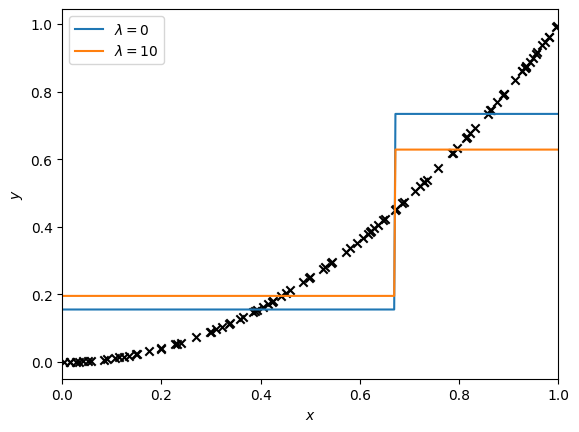

In [144]:
RNG = np.random.default_rng(seed=0)
x = RNG.uniform(size=100).reshape(-1, 1)
y = (x**2).reshape(-1)

regressor_lam0 = RuleBoostingRegressor(num_rules=2, fit_intercept=False, lam=0.0001).fit(x, y)
print('No shrinkage:')
print(regressor_lam0)
print()

regressor_lam10 = RuleBoostingRegressor(num_rules=2, fit_intercept=False, lam=10).fit(x, y)
print('Shrinkage (lambda=10):')
print(regressor_lam10)

xx = np.linspace(0, 1, 400).reshape(-1, 1)
plt.plot(xx, regressor_lam0.predict(xx), label=r'$\lambda=0$')
plt.plot(xx, regressor_lam10.predict(xx), label=r'$\lambda=10$')
plt.scatter(x, y, marker='x', color='black')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.margins(x=0)
plt.legend()
plt.show()

[1.]
[1.         0.64031242]
No shrinkage:
+0.155 if  
+0.579 if x1 >= 0.670 

[1.]
[1.         0.64031242]
Shrinkage (lambda=10):
+0.195 if  
+0.433 if x1 >= 0.670 


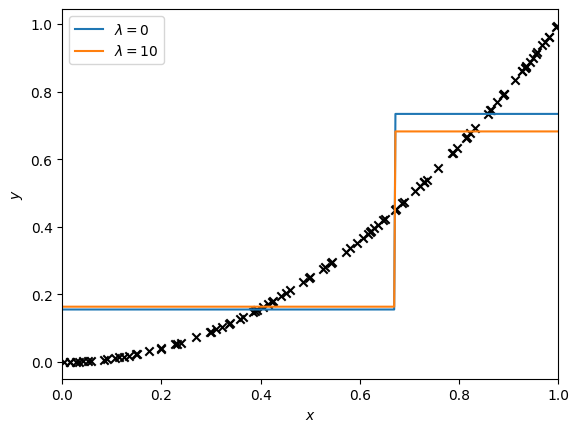

In [145]:
RNG = np.random.default_rng(seed=0)
x = RNG.uniform(size=100).reshape(-1, 1)
y = (x**2).reshape(-1)

regressor_lam0_norm = RuleBoostingRegressor(num_rules=2, fit_intercept=False, normalize_during_weight_fit=True, lam=0.0001).fit(x, y)
print('No shrinkage:')
print(regressor_lam0)
print()

regressor_lam10_norm = RuleBoostingRegressor(num_rules=2, fit_intercept=False, normalize_during_weight_fit=True, lam=10).fit(x, y)
print('Shrinkage (lambda=10):')
print(regressor_lam10)

xx = np.linspace(0, 1, 400).reshape(-1, 1)
plt.plot(xx, regressor_lam0_norm.predict(xx), label=r'$\lambda=0$')
plt.plot(xx, regressor_lam10_norm.predict(xx), label=r'$\lambda=10$')
plt.scatter(x, y, marker='x', color='black')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.margins(x=0)
plt.legend()
plt.show()